In [2]:
import sys, os
# 要添加的目录路径
custom_dir = "/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill"

# 转换为绝对路径并标准化
custom_dir = os.path.abspath(custom_dir)

# 检查路径是否存在
if not os.path.exists(custom_dir):
    raise FileNotFoundError(f"目录不存在: {custom_dir}")

# 添加到 Python 路径
if custom_dir not in sys.path:
    sys.path.insert(0, custom_dir)  # 优先搜索
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from lib.model import PiCO
from lib.resnet import SupConResNet
from utils.utils_algo import *
from utils.utils_loss import partial_loss, SupConLoss
# from utils.endoscopy_HP import load_endoscopy, load_config, PolypDataset_instances
from utils.utils_endoscopy import calculate_metrics, check_gradient_layout

In [3]:
def calculate_multilabel(   
    labels: np.ndarray,
    preds: np.ndarray,
    probs: np.ndarray,
    threshold: float = 0.5,
) -> dict:

    micro_metrics = evaluate_multilabel_micro(labels, preds, probs)
    macro_metrics = evaluate_multilabel_macro(labels, preds, probs)

    return {
        'micro': micro_metrics,
        'macro': macro_metrics,
    }

    return None


def evaluate_multilabel_micro(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    threshold: float = 0.5,
) -> dict:
    """
    评估多标签分类任务的两个模型输出，计算微平均 Sensitivity、Specificity 和 AUC。

    参数:
        labels (np.ndarray): 真实标签，形状 [N, C]，元素为 0/1。
        outputs_cls (np.ndarray): 模型输出1（如分类头），形状 [N, C]，概率值。
        outputs_prot (np.ndarray): 模型输出2（如原型头），形状 [N, C]，概率值。
        threshold (float): 概率转二进制标签的阈值（仅用于 Sensitivity/Specificity）。

    返回:
        dict: 包含两个输出的评估指标（Hamming Loss, Sensitivity, Specificity, AUC）。
    """

    # 展平为微平均计算
    y_true_flat = y_true.flatten()
    # y_proba_flat = y_proba.flatten()

    # Hamming Loss（需要二值化预测）
    if y_pred is None:
        y_pred = (y_proba > threshold).astype(int)
    y_pred_flat = y_pred.flatten()
    hl = hamming_loss(y_true, y_pred)

    # 微平均 Sensitivity (Recall) 和 Specificity
    TP = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    TN = np.sum((y_true_flat == 0) & (y_pred_flat == 0))
    FP = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    FN = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    sensitivity = TP / (TP + FN + 1e-10)
    specificity = TN / (TN + FP + 1e-10)
    F1_score = 2 * TP / (2 * TP + FP + FN + 1e-10)
    acc = (TP + TN) / (TP + TN + FP + FN)

    # AUC（无需二值化，直接基于概率）
    try:
        auc = roc_auc_score(y_true, y_proba, average="micro")
    except ValueError:
        auc = np.nan  # 处理无法计算的情况（如所有标签相同）

    return {
        "Total num": len(y_true),
        "hamming_loss": round(hl, 4),
        "sen": round(sensitivity, 4),
        "spe": round(specificity, 4),
        "acc": round(acc, 4),
        "f1": round(F1_score, 4),
        "AUC": round(auc, 4),
    }


def evaluate_multilabel_macro(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    threshold: float = 0.5,
) -> dict:
    """多标签八分类指标计算"""
    # 逐类别计算混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred)
    
    # 初始化存储
    macro_metrics = {'AUC': 0., 'mAP': 0., 'F1': 0.}
    class_metrics = []
    
    for i in range(y_true.shape[1]):

        tn, fp, fn, tp = cm[i].ravel()
        auc = roc_auc_score(y_true[:, i], y_proba[:, i])
        ap = average_precision_score(y_true[:, i], y_proba[:, i])
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        sen = tp / (tp + fn) if (tp + fn) > 0 else 0
        spe = tn / (tn + fp) if (tn + fp) > 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn)
        auc, ap, f1, spe, sen, acc = round(auc, 4), round(ap, 4), round(f1, 4), round(spe, 4), round(sen, 4), round(acc, 4)

        macro_metrics['AUC'] += auc
        macro_metrics['mAP'] += ap
        macro_metrics['F1'] += f1

        class_metrics.append({
            f'Class_{i}_AUC': auc,
            f'Class_{i}_AP': ap,
            f'Class_{i}_F1': f1,
            f'Class_{i}_Sen': sen,
            f'Class_{i}_Spe': spe,
            f'Class_{i}_Acc': acc
        })
    
    num_classes = y_true.shape[1]
    macro_metrics = {k: round(v/num_classes, 4) for k, v in macro_metrics.items()}
    macro_metrics['Class_metrics'] = class_metrics
    
    return macro_metrics

In [4]:
from types import SimpleNamespace

args = SimpleNamespace(
    # 数据集配置
    dataset='endoscopy',
    exp_dir='experiment/debug',
    
    # 模型架构
    arch='pvt_v2_b2',
    
    # 数据加载
    workers=32,
    batch_size=1,
    
    # 训练周期
    epochs=500,
    start_epoch=0,
    
    # 优化器参数
    lr=0.01,
    lr_decay_epochs='700,800,900',
    lr_decay_rate=0.1,
    cosine=False,          # action='store_true' 默认为 False
    momentum=0.9,
    weight_decay=1e-3,     # --wd 的 dest 名称
    
    # 日志与检查点
    print_freq=100,
    resume='',
    
    # 分布式训练
    world_size=1,
    rank=0,
    dist_url='tcp://localhost:10001',
    dist_backend='nccl',
    
    # 随机种子与 GPU
    seed=123,
    gpu=None,              # 默认无指定 GPU
    
    # 多进程配置
    multiprocessing_distributed=False,  # action='store_true' 默认为 False
    
    # 模型特殊参数
    num_class=8,
    low_dim=128,
    moco_queue=8192, #,8064
    moco_m=0.999,
    proto_m=0.99,
    loss_weight=0.5,
    loss_weight_bag=0.5,
    conf_ema_range='0.95,0.8',
    prot_start=0,
    partial_rate=0.1,
    pretrained=False,
    stable_queue=False,
    conf_thres=0.9,
    aggregate='Mean',
    
    # 特殊功能开关
    hierarchical=False,    # action='store_true' 默认为 False
    debug=False,           # action='store_true' 默认为 False
    add_bag_head=True,    # action='store_true' 默认为 False
    add_seg_head=False,
    pseudo_bag_sup=False,
    cls_task = 'multi_label',
    
    # 文件路径
    train_file='/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/configs/multi_center_training4/train_data.txt',
    train_bag_file = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/configs/multi_center_training4/train_data.txt',
    eval_file = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/configs/multi_center_training2/eval_data.txt',
    test_file='/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/configs/multi_center_training4/test_data.txt',
    # test_file='/mnt/data/yizhenyu/data/HP识别/workspace/PiCO/configs/multi_center_training2/test_data.txt',
)

# 验证示例参数访问
print(f"Batch size: {args.batch_size}")          # 输出 128
print(f"Learning rate: {args.lr}")               # 输出 0.01
print(f"Use cosine lr: {args.cosine}")           # 输出 False
print(f"Weight decay: {args.weight_decay}")      # 输出 0.001


Batch size: 1
Learning rate: 0.01
Use cosine lr: False
Weight decay: 0.001


In [5]:
args.aggregate = 'Mean'
args.temperature = 0.1
model = PiCO(args, SupConResNet)
model.cuda()
model.eval()
print('over')

over


In [91]:
# weight_path = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/snapshots/0904_BagDistill_ProtoCL_NewProtoScoring_2stage/checkpoint_bestInstance_37_0.95.pth.tar'
# weight_path = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/snapshots/0904_BagDistill_ProtoCL_NewProtoScoring_2stage/checkpoint.pth.tar'
# weight_path = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/snapshots/0908_BagDistill_ProtoCL_NewProtoScoring_2stage_Labelmasked0.5/checkpoint_bestInstance_40_0.944.pth.tar'
# weight_path = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/snapshots/0902_BagDistill_ProtoCL_MaskLabeledRatio_0.5/checkpoint_bestInstance_20_0.923.pth.tar'
weight_path = '/mnt/data/yizhenyu/data/HP识别/workspace/Hp-BTMIL_distill/snapshots/0912_ProtoCL_OldProtoScoring_StableQueue_protoUpdate1_Cont21_temperature0.07/checkpoint_bestInstance_31_0.952.pth.tar'

## remove the .module keys
checkpoint = torch.load(weight_path)
checkpoint = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}
model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=['bag_predict_head.fc.weight', 'bag_predict_head.fc.bias'], unexpected_keys=['queue_assis.buffer_keys', 'queue_assis.buffer_labels'])

In [7]:
from utils.endoscopy_HP_dataset import PolypDataset_bagsv2, load_config, PolypDataset_instances
debug=False
# transform_new, transform
transform_list = load_config('/mnt/data/yizhenyu/data/HP识别/workspace/PiCO/configs/transform_new.yaml')
transform_list_weak, transform_list_strong, transform_list_test = transform_list['weak'], transform_list['strong'], transform_list['test']
eval_dataset_img = PolypDataset_instances(
  num_class = args.num_class,
  index_root = args.eval_file,
  transform_list_weak=transform_list_weak,
  transform_list_strong=transform_list_strong,
  transform_list_test=transform_list_test,
  is_transform=False, size=transform_list_weak['resize']['size'][0],
  return_bag= False, is_train=False, only_labeled=True, cls_task=args.cls_task, debug=debug,args=args,
  no_both=False, no_neither=True, constrain_no_either_nums=0 #args.eval_constrain_no_neither_nums
  )#no_both=args.train_no_both, no_neither=args.train_no_neither)
eval_loader_img = torch.utils.data.DataLoader(dataset=eval_dataset_img,
  batch_size=1,
  # shuffle = False,
  shuffle=False,
  num_workers=8,
  pin_memory=True,
  # prefetch_factor=2,
  drop_last=False)

len of valid patient 342
Within Labeled data - Average candidate num:  tensor(1.2461)
Within Labeled data - labeled num of each class:  tensor([ 322,  122, 1258,  497,  431,   83,  397,  313])
labeled data num:  2747
unlabeled data num:  0


## 1. Calculate logits and features

In [92]:
prototypes = model.prototypes.cpu().numpy()
args.proto_scoring = 'v1'

In [93]:
outputs_cls, outputs_prot = [], []
labels = []
patient_ids = []
features_mlp = []
features_encoder = []
imgs = []

model.eval()
with torch.no_grad():
    for i, pack in enumerate(eval_loader_img):
        X = pack['image_eval'].cuda()
        patient_id = pack['label_corresponding_patient_index']
        patient_ids.append(patient_id.squeeze().cpu().numpy())
        labels.append(pack['label_true_8class'].view(1, -1).cuda())
        imgs.append(pack['image_eval'])
        # orders.append(pack['idx_unlabeled'].cpu())
        score_clsHead, feature_q, feat_encoder, score_prot = model(X, args=args, eval_only=True, task='img')
        outputs_cls.append(score_clsHead.view(1, -1)) # [B,C]
        outputs_prot.append(score_prot.view(1, -1))
        features_mlp.append(feature_q.view(1, -1))
        features_encoder.append(feat_encoder.view(1, -1))
        if i % (len(eval_loader_img)//20+1) == 0:
          print(i, end=' ')
outputs_cls = torch.cat(outputs_cls, dim=0).cpu().numpy()
outputs_prot = torch.cat(outputs_prot, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()
features_mlp = torch.cat(features_mlp, dim=0).cpu().numpy()
features_encoder = torch.cat(features_encoder, dim=0).cpu().numpy()
# result = evaluate_multilabel_micro_auc(labels, outputs_cls, outputs_prot)
# result = evaluate_multilabel_micro_auc(labels_concat.cpu().numpy(), outputs_cls_concat.cpu().numpy(), outputs_prot_concat.cpu().numpy())
# print(outputs_cls_concat.shape, outputs_prot_concat.shape, labels_concat.shape)


0 138 276 414 552 690 828 966 1104 1242 1380 1518 1656 1794 1932 2070 2208 2346 2484 2622 

In [49]:
calculate_multilabel(labels, outputs_cls>0.5,outputs_cls)

{'micro': {'Total num': 2747,
  'hamming_loss': 0.1604,
  'sen': 0.8434,
  'spe': 0.8389,
  'acc': 0.8396,
  'f1': 0.6209,
  'AUC': 0.9227},
 'macro': {'AUC': 0.8934,
  'mAP': 0.5984,
  'F1': 0.5061,
  'Class_metrics': [{'Class_0_AUC': 0.9373,
    'Class_0_AP': 0.7366,
    'Class_0_F1': 0.6307,
    'Class_0_Sen': 0.7981,
    'Class_0_Spe': 0.9027,
    'Class_0_Acc': 0.8904},
   {'Class_1_AUC': 0.9305,
    'Class_1_AP': 0.5931,
    'Class_1_F1': 0.4672,
    'Class_1_Sen': 0.7295,
    'Class_1_Spe': 0.9352,
    'Class_1_Acc': 0.9261},
   {'Class_2_AUC': 0.9405,
    'Class_2_AP': 0.9299,
    'Class_2_F1': 0.8498,
    'Class_2_Sen': 0.9245,
    'Class_2_Spe': 0.7878,
    'Class_2_Acc': 0.8504},
   {'Class_3_AUC': 0.895,
    'Class_3_AP': 0.6523,
    'Class_3_F1': 0.5984,
    'Class_3_Sen': 0.8471,
    'Class_3_Spe': 0.7827,
    'Class_3_Acc': 0.7943},
   {'Class_4_AUC': 0.8701,
    'Class_4_AP': 0.6111,
    'Class_4_F1': 0.5232,
    'Class_4_Sen': 0.8097,
    'Class_4_Spe': 0.7608,
    'Cl

# T-SNE

In [ ]:
import random
from collections import defaultdict

def balance_samples(features_single, features_mlp_single, labels_single, count_max=None, count_bg=1000):
    """
    按类别平衡样本，使每个类别的样本数等于最少类别的样本数。
    
    Args:
        features_single (list): 特征列表
        features_mlp_single (list): MLP 特征列表
        labels_single (list): 标签列表（值范围：{0, ..., 8}）
    
    Returns:
        new_features_single (list): 平衡后的特征列表
        new_features_mlp_single (list): 平衡后的 MLP 特征列表
        new_labels_single (list): 平衡后的标签列表
    """
    # 按标签分组
    cls_num = np.array(labels_single).max() + 1
    grouped = defaultdict(list)
    for f, f_mlp, l in zip(features_single, features_mlp_single, labels_single):
        grouped[l].append((f, f_mlp, l))  # 保存标签以便合并
    # 统计每个类别的样本数量
    counts = {label: len(samples) for label, samples in grouped.items()}
    print("ori", [counts[l] for l in range(cls_num)])
    # min_count =   # 找到最小类别数量
    min_count = count_max if count_max is not None else min(counts.values())
    # 对每个类别进行随机抽样
    balanced_samples = []
    for label, samples in grouped.items():
        if len(samples) > min_count and label < 8:
            samples = random.sample(samples, min_count)  # 随机欠采样
        elif label == 8:
            samples = random.sample(samples, count_bg)
        balanced_samples.extend(samples)

    # 分离抽样后的样本
    new_features_single = [s[0] for s in balanced_samples]
    new_features_mlp_single = [s[1] for s in balanced_samples]
    new_labels_single = [s[2] for s in balanced_samples]

    grouped = defaultdict(list)
    for f, f_mlp, l in zip(new_features_single, new_features_mlp_single, new_labels_single):
        grouped[l].append((f, f_mlp, l))  # 保存标签以便合并
    # 统计每个类别的样本数量
    counts = {label: len(samples) for label, samples in grouped.items()}
    print("new", [counts[l] for l in range(cls_num)])
    return new_features_single, new_features_mlp_single, new_labels_single


In [133]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 输入数据：X (n_samples, n_features), y (n_samples,) 包含8个类别的标签
# Step1: PCA降维到50D（保留主要信息）

def t_SNE_vis(feat, label, perplexity=[30]):
  cls_num = np.unique(label).shape[0]

  for pp in perplexity:
    pca = PCA(n_components=min(50, feat.shape[0]))
    feat_pca = pca.fit_transform(feat)
    X_tsne = TSNE(n_components=2, random_state=33, perplexity=pp).fit_transform(feat_pca)
    X_tsne_dataset_i = X_tsne[:, :]
    y_dataset_i = label[:]

    plt.figure()
    class_colors = ['blue', 'red', 'darkgray', 'green', 'orange', 'purple', 'brown', 'pink', 'yellow', 'cyan'][:cls_num]
    class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"][:cls_num]
    # for class_i, color_i, name_i in zip(range(3), class_colors, class_names):
    #     print(class_i, color_i, name_i)
    for class_i, color_i, name_i in zip(range(cls_num), class_colors, class_names):
        plt.scatter(X_tsne_dataset_i[y_dataset_i == class_i, 0],
                    X_tsne_dataset_i[y_dataset_i == class_i, 1],
                    c=color_i, label=name_i, s=20, alpha=0.3)
    plt.legend()
    plt.axis('off')
    # with open('X_tsne_dataset_i.txt', 'a') as f:
    #     f.write(str(auc) + '\n')

  plt.show()
  return 0

def t_SNE_vis_proto(feat, label, prototypes=None, perplexity=[30]):
    """
    可视化特征和原型的 t-SNE 图，特征用散点，原型用五角星。

    参数:
        feat (np.ndarray): 特征数据 [N, E]
        label (np.ndarray): 特征数据对应的标签 [N,]
        prototypes (np.ndarray): 原型数据 [K, E]
        perplexity (list): t-SNE 的 perplexity 参数列表
    """

    # prot_neg = prototypes[1:3].mean(axis=0)
    # prot_pos = prototypes[3:].mean(axis=0)
    # prototypes = np.concatenate([prot_neg[None, :], prot_pos[None, :], prototypes], axis=0)
    cls_num = np.unique(label).shape[0]
    
    for pp in perplexity:
        # 对特征进行 PCA + t-SNE
        pca = PCA(n_components=min(50, feat.shape[0]))
        if prototypes is not None:
          prototypes = np.concatenate([prototypes[1:],prototypes[0][None, :]], axis=0)
          feat = np.concatenate([feat, prototypes]) #[N+K,E]
          feat_pca = pca.fit_transform(feat)
          X_tsne = TSNE(n_components=2, random_state=33, perplexity=pp).fit_transform(feat_pca)
          X_tsne_prot = X_tsne[-prototypes.shape[0]:, :]
          X_tsne = X_tsne[:-prototypes.shape[0]]
        else:
          feat_pca = pca.fit_transform(feat)
          X_tsne = TSNE(n_components=2, random_state=33, perplexity=pp).fit_transform(feat_pca)
        # 绘图
        plt.figure(figsize=(10, 8))

        # 画特征数据点
        class_colors = colors = [
          'darkblue',      # 蓝色系 - 深
          'skyblue',       # 蓝色系 - 浅
          'crimson',       # 红色系 - 深
          'salmon',        # 红色系 - 浅
          'forestgreen',   # 绿色系 - 深
          'lightgreen',    # 绿色系 - 浅
          'darkgoldenrod', # 黄色系 - 深
          'khaki',          # 黄色系 - 浅
          'gray'
        ][:cls_num]
        class_names = ["RAC", "FGP", "GA", "PE-F/B", "DE", "NG", "WTM", "TGF", "Background"][:cls_num]
        for class_i, color_i, name_i in zip(range(cls_num), class_colors, class_names):
            plt.scatter(X_tsne[label == class_i, 0],
                        X_tsne[label == class_i, 1],
                        c=color_i, s=20, alpha=0.3)

            # 画原型点（五角星）
            if prototypes is not None:
              plt.scatter(X_tsne_prot[class_i, 0], X_tsne_prot[class_i, 1],
                          c=color_i, marker='*', s=200, label=name_i+'_prot', edgecolor='black')

        # plt.scatter(X_tsne_prot[0, 0], X_tsne_prot[0, 1],
        #                 c='blue', marker='v', s=200, label='neg_prot', edgecolor='black')
        # plt.scatter(X_tsne_prot[1, 0], X_tsne_prot[1, 1],
        #                 c='red',marker='v', s=200, label='pos_prot', edgecolor='black')
        # plt.scatter(X_tsne_prot[0, 0], X_tsne_prot[0, 1],
        #                 c='black', marker='v', s=200, label='bg_prot', edgecolor='black')
        # 图例和样式
        plt.legend()
        plt.axis('off')
        # plt.title(f't-SNE Visualization (Perplexity={pp})', fontsize=14)
        print(f't-SNE Visualization (Perplexity={pp})')
        plt.show()

In [ ]:
import umap

def UMAP_vis_proto(feat, label, prototypes=None, n_neighbors=[15]):
    """
    使用 UMAP 可视化特征和原型的关系。
    
    参数:
        feat (np.ndarray): 特征数据 [N, E]
        label (np.ndarray): 标签 [N,]
        prototypes (np.ndarray): 原型数据 [K, E]
        n_neighbors (list): UMAP 的 n_neighbors 参数列表
    """
    cls_num = np.unique(label).shape[0]
    
    for n in n_neighbors:
        # PCA 预降维
        pca = PCA(n_components=50)
        if prototypes is not None:
            # 拼接原型与特征
            prototypes = np.concatenate([prototypes[1:], prototypes[0][None, :]], axis=0)
            feat = np.concatenate([feat, prototypes], axis=0)
            feat_pca = pca.fit_transform(feat)
            
            # UMAP 降维
            reducer = umap.UMAP(n_components=2, random_state=33, n_neighbors=n, min_dist=0.1)
            X_umap = reducer.fit_transform(feat_pca)
            
            # 分离原型
            X_umap_prot = X_umap[-prototypes.shape[0]:, :]
            X_umap = X_umap[:-prototypes.shape[0], :]
        else:
            feat_pca = pca.fit_transform(feat)
            reducer = umap.UMAP(n_components=2, random_state=33, n_neighbors=n, min_dist=0.1)
            X_umap = reducer.fit_transform(feat_pca)
        
        # 绘图
        plt.figure(figsize=(10, 8))
        
        # 定义颜色和类别名
        class_colors = [
            'darkblue',      # 蓝色系 - 深
            'skyblue',       # 蓝色系 - 浅
            'crimson',       # 红色系 - 深
            'salmon',        # 红色系 - 浅
            'forestgreen',   # 绿色系 - 深
            'lightgreen',    # 绿色系 - 浅
            'darkgoldenrod', # 黄色系 - 深
            'khaki',         # 黄色系 - 浅
            'gray'
        ][:cls_num]
        class_names = ["RAC", "FGP", "GA", "PE-F/B", "DE", "NG", "WTM", "TGF", "Background"][:cls_num]
        
        # 绘制特征点
        for class_i, color_i, name_i in zip(range(cls_num), class_colors, class_names):
            plt.scatter(X_umap[label == class_i, 0],
                        X_umap[label == class_i, 1],
                        c=color_i, s=20, alpha=0.3)
            
            # 绘制原型（五角星）
            if prototypes is not None:
                plt.scatter(X_umap_prot[class_i, 0], X_umap_prot[class_i, 1],
                            c=color_i, marker='*', s=200, label=name_i, edgecolor='black')
            else:
                plt.scatter(X_umap[label == class_i, 0].mean(), X_umap[label == class_i, 1].mean(),
                            c=color_i, marker='*', s=200, label=name_i, edgecolor='black')
        plt.legend()
        plt.axis('off')
        # plt.title(f'UMAP Visualization (n_neighbors={n})', fontsize=14)
        print(f'UMAP Visualization (n_neighbors={n})')
        plt.show()


In [ ]:
features_single, features_mlp_single, labels_single = [], [], []
for i, label in enumerate(labels):
  
  if sum(label) == 1:
    features_single.append(features_encoder[i])
    features_mlp_single.append(features_mlp[i])
    labels_single.append(np.where(label == 1)[0][0])
  elif sum(label) == 0:
    features_single.append(features_encoder[i])
    features_mlp_single.append(features_mlp[i])
    labels_single.append(8)
features_single = np.array(features_single)
features_mlp_single = np.array(features_mlp_single)
labels_single = np.array(labels_single)
print(features_single.shape, features_mlp_single.shape, labels_single.shape,prototypes.shape)

(2190, 512) (2190, 128) (2190,) (9, 128)


In [ ]:
features_single, features_mlp_single, labels_single = balance_samples(features_single, features_mlp_single, labels_single, count_max=200, count_bg=200)
features_single = np.array(features_single)
features_mlp_single = np.array(features_mlp_single)
labels_single = np.array(labels_single)
print(features_single.shape, features_mlp_single.shape, labels_single.shape)

ori [282, 89, 1087, 211, 151, 43, 186, 141]
new [200, 89, 200, 200, 151, 43, 186, 141]
(1210, 512) (1210, 128) (1210,)


t-SNE Visualization (Perplexity=30)


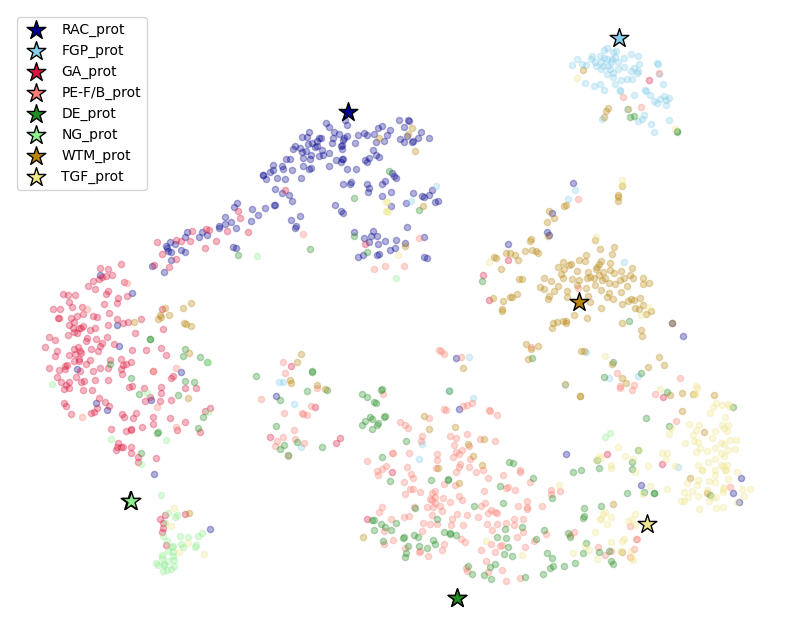

In [ ]:
t_SNE_vis_proto(features_mlp_single, labels_single, prototypes, perplexity=[30])
# t_SNE_vis_proto(features_single, labels_single, perplexity=[30])

/mnt/data/yizhenyu/conda/envs/polypdetect/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP Visualization (n_neighbors=15)


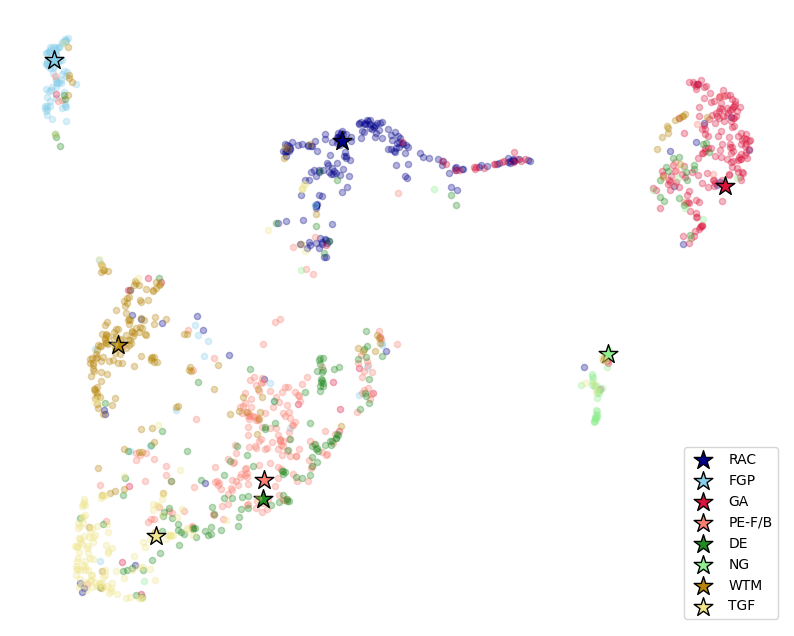

In [ ]:
UMAP_vis_proto(features_mlp_single, labels_single, prototypes, n_neighbors=[15])

# de-redundancy

In [58]:
def create_mask_drop(attention_matrix, theta):
    """｜
    Generate the mask_drop matrix based on the attention matrix and threshold.

    Parameters:
        attention_matrix (np.ndarray): A 2D numpy array of shape (n, n).
        theta (float): Threshold for binarizing the attention matrix.

    Returns:
        mask_drop (np.ndarray): A 2D numpy array of shape (n, n).
    """
        
    epsilon = 1e-8  # Avoid division by zero

    # Step 1: Binarize the attention matrix into mask
    mask = (attention_matrix >= theta).astype(np.float32)
    print(mask)
    # Step 2: Compute row sums of the attention matrix
    row_sums = np.sum(attention_matrix*mask, axis=1, keepdims=True)
    # Step 3: Construct mask_drop
    mask_drop = np.where(mask == 1, 1.0 / (row_sums + epsilon), 1.0)

    ## 
    # row_sums = np.sum(attention_matrix, axis=1, keepdims=True)
    # mask_drop = 1.0 / (row_sums + epsilon)

    return mask_drop


In [11]:
imgs_np = torch.cat(imgs, dim=0).numpy()

In [32]:
args.temperature

0.1

In [144]:
from collections import Counter
patient_ids = np.array(patient_ids).tolist()
Counter(patient_ids)

Counter({114: 45,
         127: 33,
         29: 28,
         39: 25,
         27: 24,
         113: 24,
         108: 23,
         346: 23,
         80: 22,
         22: 21,
         58: 21,
         99: 21,
         86: 20,
         115: 20,
         141: 20,
         41: 18,
         42: 18,
         47: 18,
         53: 18,
         143: 18,
         26: 17,
         38: 17,
         97: 17,
         111: 17,
         136: 17,
         274: 17,
         5: 16,
         28: 16,
         33: 16,
         128: 16,
         147: 16,
         159: 16,
         250: 16,
         2: 15,
         14: 15,
         48: 15,
         126: 15,
         140: 15,
         150: 15,
         151: 15,
         10: 14,
         13: 14,
         51: 14,
         64: 14,
         112: 14,
         149: 14,
         167: 14,
         248: 14,
         249: 14,
         335: 14,
         7: 13,
         11: 13,
         34: 13,
         52: 13,
         74: 13,
         94: 13,
         168: 13,
        

In [148]:
patient_ids = np.array(patient_ids)
patient_ids == chose_patient

array([False, False, False, ..., False, False, False])

[[1. 1. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]]


<Axes: >

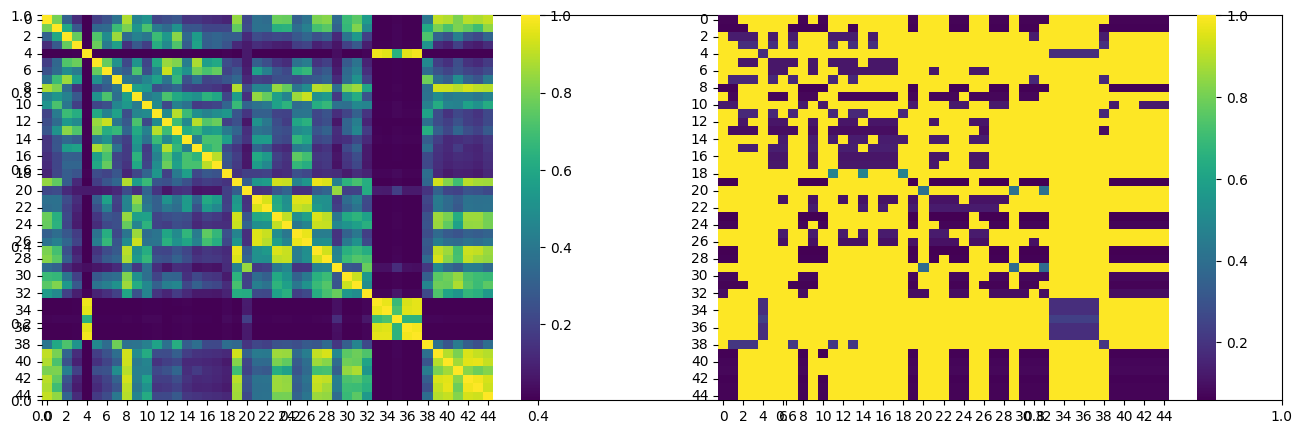

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.subplots(figsize=(16, 5))

# chose_patient = patient_ids[300]
chose_patient = 114
z_norm = features_mlp[patient_ids == chose_patient]
# z_norm = features_mlp[:30]
# z_norm = np.concatenate(features_mlp_idx, axis=0)

# cos_sim = z_norm.squeeze()@z_norm.squeeze().T  # [-1, 1]
# squared_distance = 2 * (1 - cos_sim)  # 更高效且数值稳定
# combined_adj_sim1 = np.exp(-1.0 * squared_distance / (2 * 1 ** 2))

combined_adj_sim1 = np.exp(z_norm @ z_norm.T/args.temperature)
# combined_adj_sim1 = z_norm @ z_norm.T/args.temperature
# combined_adj_sim1 = (combined_adj_sim1 - combined_adj_sim1.min())/(combined_adj_sim1.max()-combined_adj_sim1.min())
combined_adj_sim1 = combined_adj_sim1 / combined_adj_sim1.max()
# combined_adj_sim1 = 1 / (1+np.exp(-1.0 * combined_adj_sim1))
# plt.imshow(combined_adj_sim)
plt.subplot(1, 2, 1)
sns.heatmap(combined_adj_sim1, cmap='viridis')

# plt.imshow(combined_adj_sim)
plt.subplot(1, 2, 2)
# sns.heatmap(combined_adj_sim, cmap='viridis')
mask_drop = create_mask_drop(combined_adj_sim1, 0.5)
sns.heatmap(mask_drop, cmap='viridis')

In [152]:
z_norm.shape

(45, 128)

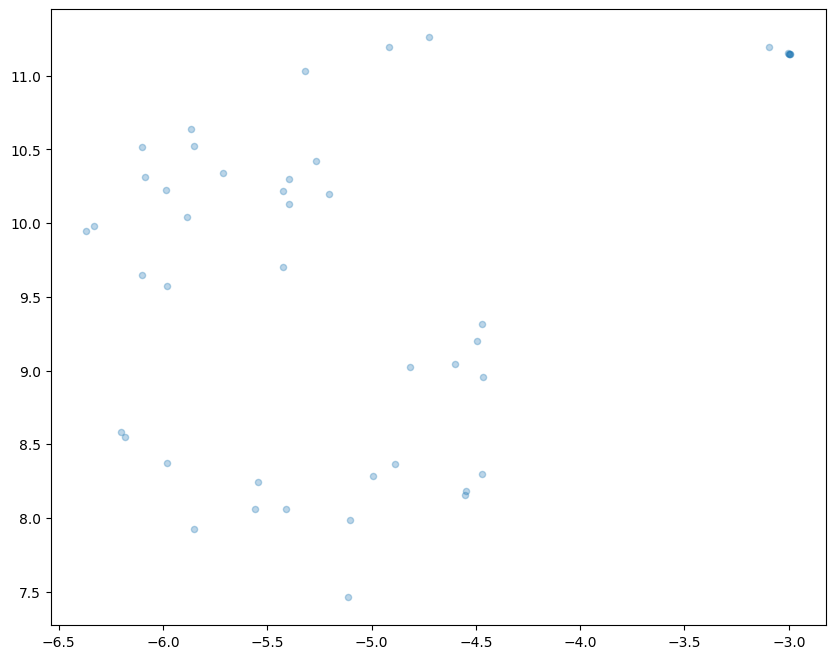

In [155]:
# 假设 z_norm 是输入特征矩阵
labels = np.arange(z_norm.shape[0])  # [K]
feat = z_norm

# PCA + t-SNE 降维
pca = PCA(n_components=min(50, feat.shape[0]))
feat_pca = pca.fit_transform(feat)
X_tsne = TSNE(n_components=2, random_state=33, perplexity=30).fit_transform(feat_pca)

# 绘图
plt.figure(figsize=(10, 8))

# 使用颜色映射
sc = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=labels,  # 按 labels 赋色
    cmap='viridis',  # 选择色阶（可替换为 'plasma', 'coolwarm' 等）
    s=20, 
    alpha=0.3
)

# 添加颜色条
plt.colorbar(sc, label='Label')

plt.title("t-SNE Visualization with Label Color Mapping")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [100]:
# combined_adj_sim1.mean(), combined_adj_sim1.min(), combined_adj_sim1.max()
combined_adj_sim1

array([[0.99999815, 0.74876827, 0.7728551 , 0.00951336, 0.00677348,
        0.00584017, 0.00528785],
       [0.74876827, 0.99999714, 0.9519289 , 0.01296701, 0.00858801,
        0.00731512, 0.00652187],
       [0.7728551 , 0.9519289 , 0.99999714, 0.01165457, 0.00828633,
        0.00714334, 0.00640193],
       [0.00951336, 0.01296701, 0.01165457, 0.99999714, 0.33551562,
        0.34212425, 0.29238945],
       [0.00677348, 0.00858801, 0.00828633, 0.33551562, 1.        ,
        0.97705775, 0.95403737],
       [0.00584017, 0.00731512, 0.00714334, 0.34212425, 0.97705775,
        0.99999905, 0.98087436],
       [0.00528785, 0.00652187, 0.00640193, 0.29238945, 0.95403737,
        0.98087436, 0.99999714]], dtype=float32)

In [73]:
mask_drop.max(), mask_drop.min()

(1.0000057, 1.0)

In [51]:
# Step 1: Binarize the attention matrix into mask
mask = (combined_adj_sim1 >= 0.9).astype(np.float32)
# Step 2: Compute row sums of the attention matrix
row_sums = np.sum(combined_adj_sim1*mask, axis=1, keepdims=True)
1/row_sums

array([[1.       ],
       [1.       ],
       [1.0000057],
       [1.000001 ],
       [1.       ],
       [1.000001 ],
       [1.000001 ]], dtype=float32)

In [113]:
imgs_s = imgs_np[patient_ids == chose_patient]
imgs_s.shape

(14, 3, 352, 352)

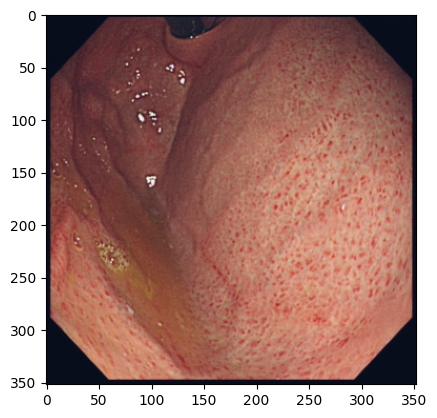

In [125]:
imgshow = imgs_s[12].transpose(1,2,0)
imgshow = (imgshow-imgshow.min())/(imgshow.max()-imgshow.min())
plt.imshow(imgshow)

In [82]:
combined_adj_sim1 = np.exp(z_norm @ z_norm.T/args.temperature)
combined_adj_sim1.mean(), combined_adj_sim1.min(), combined_adj_sim1.max()

(4629.2954, 0.43484864, 22026.508)

In [ ]:
cos_sim.mean(), cos_sim.min(), cos_sim.max()

(0.76909965, 0.46142155, 1.0000002)

In [ ]:
squared_distance.mean(), squared_distance.min(), squared_distance.max()

(0.46180066, -4.7683716e-07, 1.0771569)

In [ ]:
mask_drop.mean(), mask_drop.min(), mask_drop.max()

(0.73840046, 0.084216714, 1.0000001)

In [ ]:
mask_drop

array([[0.16044813, 0.16044813, 0.16044813, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.15179597, 0.15179597, 0.15179597, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.15078717, 0.15078717, 0.15078717, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.16470496, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.16470496],
       [1.        , 1.        , 1.        , 1.        , 0.18096867,
        1.        , 1.        , 1.        , 1.        , 0.18096867],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        0.22235747, 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.17029488, 0.17029488, 0.17029488, 1.        ],
       [1.        , 1.        , 1.       